In [7]:
import numpy as np
import keras
import csv
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import calendar

## 1.upload data

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1GImf6ZeF8ZeDv-F_lAbObzPNSLfNTACD4zP0u82eLqY/edit#gid=595628091'
csv_export_url = url.replace('/edit#gid=', '/export?format=csv&gid=')
# local_dir = 'C:\\Users\\zhang\\Desktop\\work\\percolata\\ML Interview dataset (Percolata confidential).xlsx'
df = pd.read_csv(csv_export_url)

In [3]:
df.head()

,BUSIND_ID,FISCAL_DATE,PERIOD_ID,GROUND_TRUTH
0,1,2018-02-03,15:15:00,1.0
1,1,2018-12-01,14:45:00,3.0
2,1,2015-05-15,9:30:00,2.0
3,1,2015-02-03,20:15:00,4.0
4,1,2015-03-07,16:45:00,0.0


## 2.preprocessing data
### 2.1 convert BUSIND_ID and GROUND_TRUTH into feature value

### 2.2 aggregate date and time into timestamp, group by same time
--> output a ready to used panda dataframe 'data'

In [4]:
df['TimeStamp']=pd.to_datetime(df.FISCAL_DATE.astype(str)+' '+df.PERIOD_ID.astype(str))
df.drop(['FISCAL_DATE', 'PERIOD_ID'], axis=1, inplace=True)

In [5]:
RX_filled = df[df.BUSIND_ID == 1].sort_values('TimeStamp').loc[:,['TimeStamp','GROUND_TRUTH']]
RX_sold = df[df.BUSIND_ID == 2].sort_values('TimeStamp').loc[:,['TimeStamp','GROUND_TRUTH']] 
Gen_sale = df[df.BUSIND_ID == 3].sort_values('TimeStamp').loc[:,['TimeStamp','GROUND_TRUTH']]
Gen_items = df[df.BUSIND_ID == 4].sort_values('TimeStamp').loc[:,['TimeStamp','GROUND_TRUTH']]
Gen_trans = df[df.BUSIND_ID == 5].sort_values('TimeStamp').loc[:,['TimeStamp','GROUND_TRUTH']]

RX_filled.rename(columns={'GROUND_TRUTH':'RX_filled'}, inplace=True)
RX_sold.rename(columns={'GROUND_TRUTH':'RX_sold'}, inplace=True)
Gen_sale.rename(columns={'GROUND_TRUTH':'Gen_sale'}, inplace=True)
Gen_items.rename(columns={'GROUND_TRUTH':'Gen_items'}, inplace=True)
Gen_trans.rename(columns={'GROUND_TRUTH':'Gen_trans'}, inplace=True)

In [8]:
data = Gen_items.merge(Gen_sale,left_on='TimeStamp', right_on='TimeStamp',how='left')
data = data.merge(Gen_trans,left_on='TimeStamp', right_on='TimeStamp',how='left')
data = data.merge(RX_filled,left_on='TimeStamp', right_on='TimeStamp',how='left')
data = data.merge(RX_sold,left_on='TimeStamp', right_on='TimeStamp',how='left')
data['Date'] = [d.date() for d in data['TimeStamp']]
data['year'] = [d.year-2015 for d in data['TimeStamp']]
data['month'] = [d.month for d in data['TimeStamp']]
data['day'] = [d.day for d in data['TimeStamp']]
data['week']=data['Date'].apply(lambda x: calendar.day_name[x.weekday()])  
data['Time'] = [d.time() for d in data['TimeStamp']]
data['time_value'] = [(d.hour-7)*4+(d.minute/15) for d in data['TimeStamp']]
data = data[(data.Time> dt.time(6,50,0)) & (data.Time< dt.time(21,50,0))]
print(data.shape)
data.head()

(87535, 13)


,TimeStamp,Gen_items,Gen_sale,Gen_trans,RX_filled,RX_sold,Date,year,month,day,week,Time,time_value
0,2015-01-01 07:00:00,4.0,21.24,2.0,NaN,NaN,2015-01-01,0,1,1,Thursday,07:00:00,0.0
1,2015-01-01 07:15:00,0.0,0.00,0.0,NaN,NaN,2015-01-01,0,1,1,Thursday,07:15:00,1.0
2,2015-01-01 07:30:00,0.0,0.00,0.0,NaN,NaN,2015-01-01,0,1,1,Thursday,07:30:00,2.0
3,2015-01-01 07:45:00,0.0,0.00,0.0,NaN,NaN,2015-01-01,0,1,1,Thursday,07:45:00,3.0
4,2015-01-01 08:00:00,2.0,6.00,1.0,NaN,NaN,2015-01-01,0,1,1,Thursday,08:00:00,4.0


## 3.understand data by analysis each feature and correlation and plot
### use gen_sale as the first view data, because gen_trans and gen_items are high related

D:\Anaconda\envs\test_env_3.7\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\test_env_3.7\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


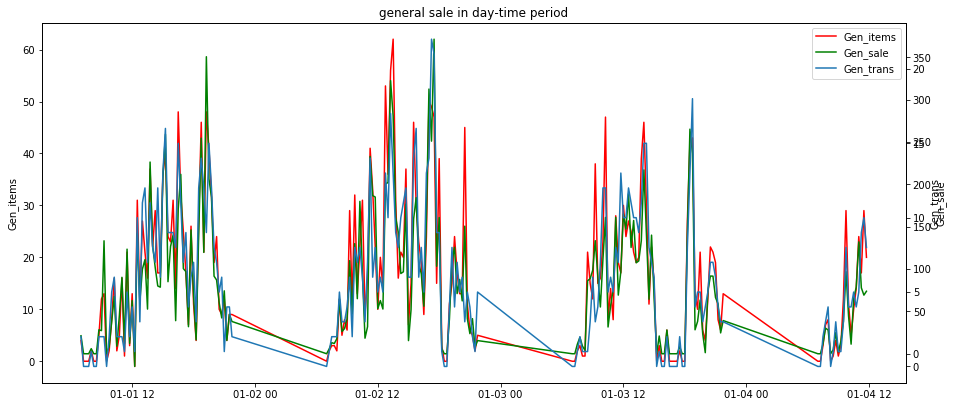

In [9]:
# plot a data-time Gen sold value
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax3 = fig.add_axes()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

lns1=ax1.plot(data['TimeStamp'][0:200],data['Gen_items'][0:200],label='Gen_items',color = 'r')
ax1.set_ylabel('Gen_items')

lns2=ax2.plot(data['TimeStamp'][0:200],data['Gen_sale'][0:200],label='Gen_sale',color='g')
ax2.set_ylabel('Gen_sale')
lns3=ax3.plot(data['TimeStamp'][0:200],data['Gen_trans'][0:200],label='Gen_trans')
ax3.set_ylabel('Gen_trans')

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
fig.tight_layout()
plt.title('general sale in day-time period')
plt.show()

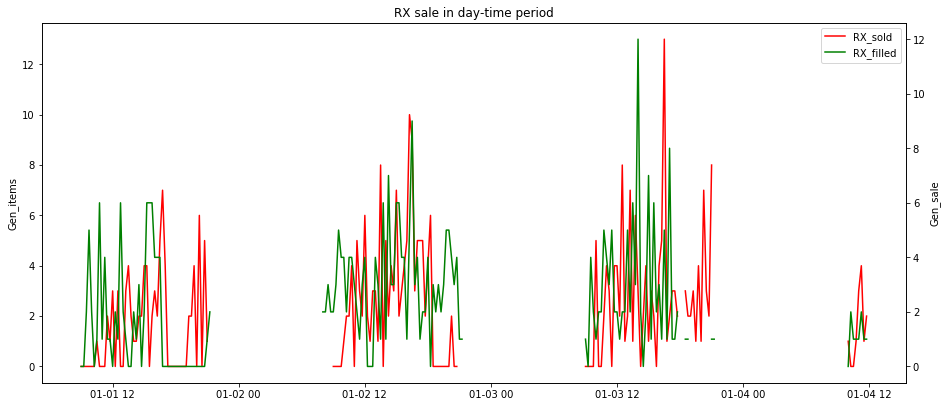

In [10]:
# plot a data-time RX sold value
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()

lns1=ax1.plot(data['TimeStamp'][0:200],data['RX_sold'][0:200],label='RX_sold',color = 'r')
ax1.set_ylabel('Gen_items')

lns2=ax2.plot(data['TimeStamp'][0:200],data['RX_filled'][0:200],label='RX_filled',color='g')
ax2.set_ylabel('Gen_sale')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
fig.tight_layout()
plt.title('RX sale in day-time period')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

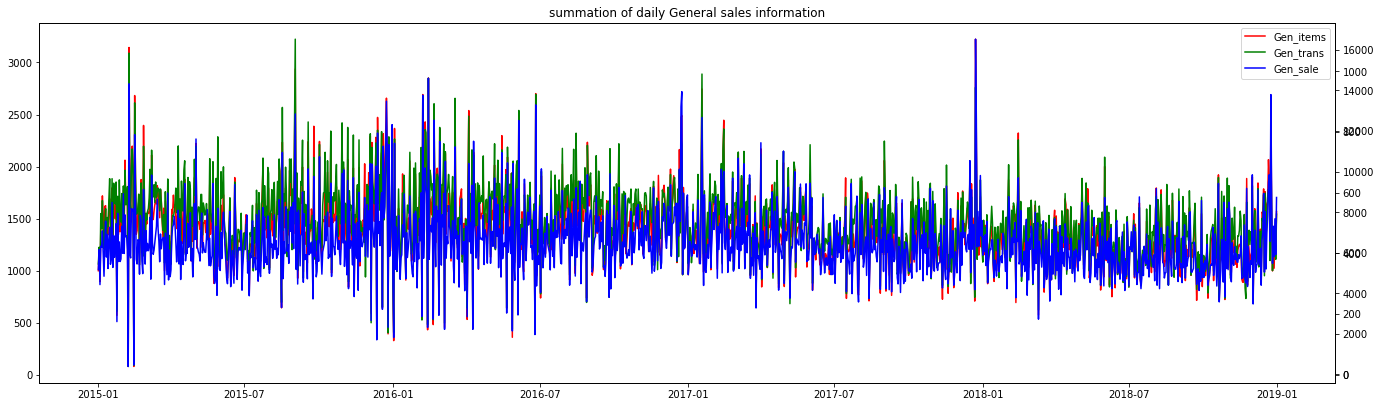

In [11]:

## plot total amount year period sale value
day_sum = data.groupby(['Date']).sum().reset_index()
start_date = dt.date(2015,5,1)
end_date = dt.date(2017,5,1)
mask = (day_sum['Date'] > start_date) & (day_sum['Date'] <= end_date)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()
ax3 = fig.add_axes()
ax3 = ax1.twinx()

lns1=ax1.plot(day_sum.Date,day_sum.Gen_items,label='Gen_items',color='r')
lns2=ax2.plot(day_sum.Date,day_sum.Gen_trans,label='Gen_trans',color='g')
lns3=ax3.plot(day_sum.Date,day_sum.Gen_sale,label='Gen_sale',color='b')

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('summation of daily General sales information')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

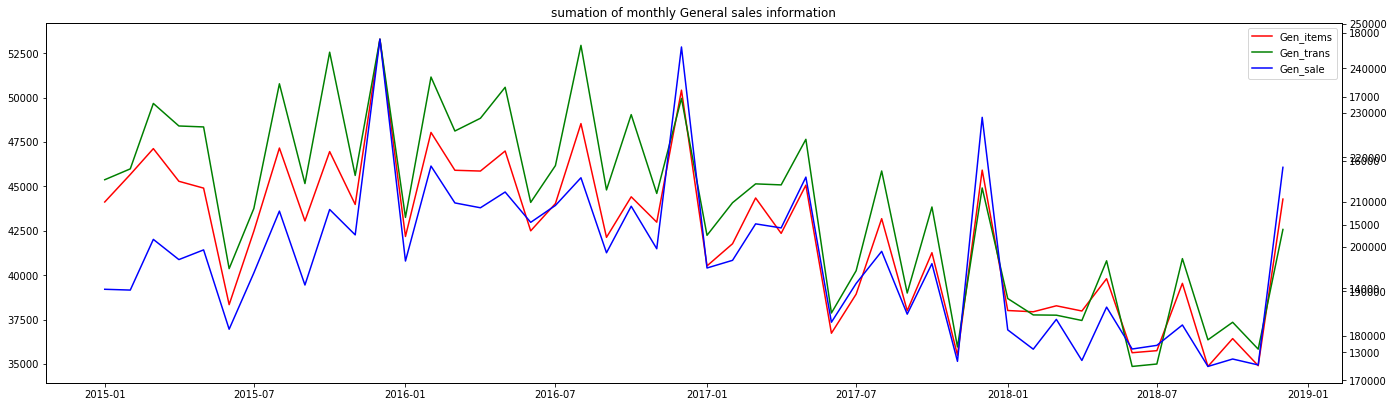

In [12]:
## sales trend in month scale
day_sum['group_date'] = day_sum['Date'].apply(lambda x: dt.datetime(x.year,x.month,1) )
month_sum = day_sum.groupby(day_sum.group_date).sum().reset_index()

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()
ax3 = fig.add_axes()
ax3 = ax1.twinx()

lns1=ax1.plot(month_sum.group_date,month_sum.Gen_items,label='Gen_items',color='r')
lns2=ax2.plot(month_sum.group_date,month_sum.Gen_trans,label='Gen_trans',color='g')
lns3=ax3.plot(month_sum.group_date,month_sum.Gen_sale,label='Gen_sale',color='b')

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('sumation of monthly General sales information')
plt.show

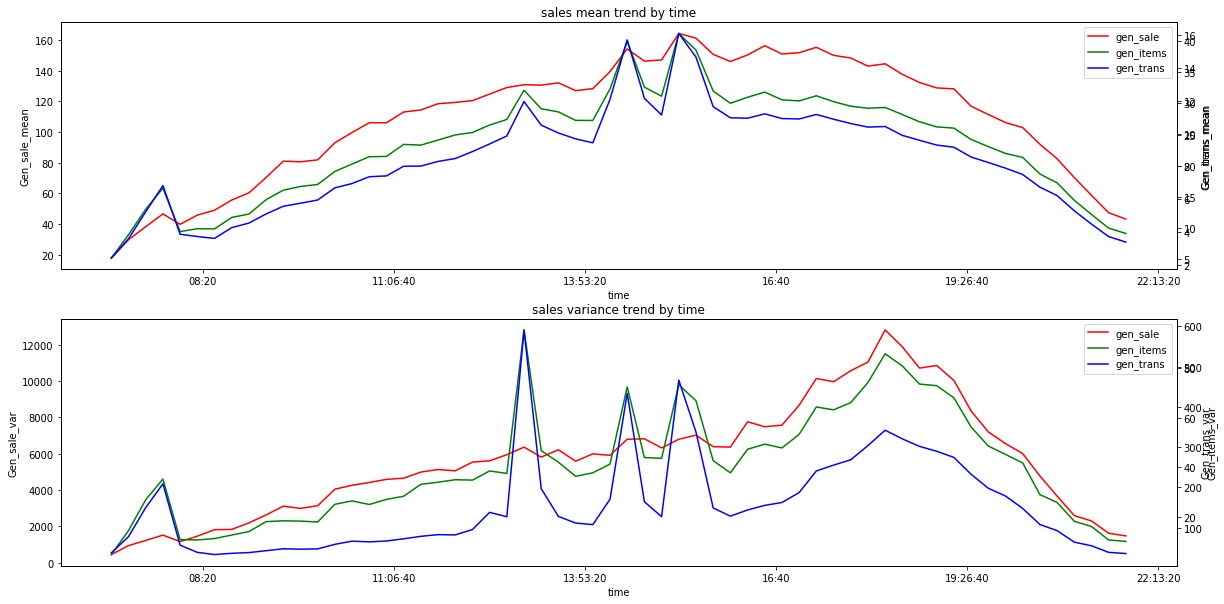

In [13]:
# mean and variance of sale data with different time

mean = data.groupby(['Time']).mean().reset_index()
var = data.groupby(['Time']).var().reset_index()

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))

# ax1 = fig.add_axes([0, 0, 1, 1])
# ax2 = fig.add_axes()
# ax2 = ax1.twinx()
# ax3 = fig.add_axes()
ax1_1 = ax1.twinx()
ax1_2 = ax1.twinx()

lns1=ax1.plot(mean['Time'],mean['Gen_sale'],label='gen_sale',color = 'r')
ax1.set_ylabel('Gen_sale_mean')

lns2=ax1_1.plot(mean['Time'],mean['Gen_items'],label='gen_items',color='g')
ax1_1.set_ylabel('Gen_items_mean')

lns3=ax1_2.plot(mean['Time'],mean['Gen_trans'],label='gen_trans',color='b')
ax1_2.set_ylabel('Gen_trans_mean')

leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('sales mean trend by time')

ax2_1 = ax2.twinx()
ax2_2 = ax2.twinx()

lns4=ax2.plot(var['Time'],var['Gen_sale'],label='gen_sale',color = 'r')
ax2.set_ylabel('Gen_sale_var')

lns5=ax2_1.plot(var['Time'],var['Gen_items'],label='gen_items',color='g')
ax2_1.set_ylabel('Gen_items_var')

lns6=ax2_2.plot(var['Time'],var['Gen_trans'],label='gen_trans',color='b')
ax2_2.set_ylabel('Gen_trans_var')

leg = lns4 + lns5 + lns6
labs = [l.get_label() for l in leg]
ax2.legend(leg, labs, loc=0)
plt.title('sales variance trend by time')

plt.show()

In [14]:
## find relation between each feature
print('correlation between Gen_items and Gen_sale is: ',data['Gen_items'].corr(data['Gen_sale']))
print('correlation between Gen_items and Gen_trans is: ',data['Gen_items'].corr(data['Gen_trans']))
print('correlation between Gen_sale and Gen_trans is: ',data['Gen_sale'].corr(data['Gen_trans']))
print('correlation between RX_filled and RX_sold is: ',data['RX_filled'].corr(data['RX_sold']))

correlation between Gen_items and Gen_sale is:  0.8720933090315609
correlation between Gen_items and Gen_trans is:  0.8736419537426136
correlation between Gen_sale and Gen_trans is:  0.7865047493817428
correlation between RX_filled and RX_sold is:  0.07668614943359932


In [516]:
training_data = np.array(data['Gen_items'])

### Understanding data based on previous visulization
1. In multi-day scale, sales goes periodical
2. In totally time scale, sales by day has no specifical sign on trend 
3. In month scale, sales get periodical, maximum in December, min in Jan, the trend goes little down
4. In one day scale, sales by time goes periodical, maximum in 15:00 to 16:00
5. For RX data, it seems a delay between RX_sale and RX_filled
6. Gen_sale and Gen_item has high correlation, Gen_item and Gen_trans has high correlation

## 4.build a baseline model-->
#### one way is use mean of previous data
#### other way is build a machine learning model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor 
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor

### 4.0 data preprocessing and generation

In [15]:
## need predict first month in 2019, the data will be : 60*30 = 1800 lines
def data_generator(begin_year,begin_month,begin_date,length):
    new_data = []
    for i in range(0,length):
        for j in range(0,60):
            #new_time = dt.time(7+int(j/4),15*(j%4))
            new_date = dt.datetime(begin_year,begin_month,begin_date+i,7+int(j/4),15*(j%4),0)
            new_data.append(new_date)

    new_data = pd.DataFrame(new_data,columns = ['TimeStamp'])
    return new_data

new_data = data_generator(2018,12,1,30)

In [16]:
def data_transform(input_data):
    input_data['year'] = [d.year-2015 for d in input_data['TimeStamp']]
    input_data['month'] = [d.month for d in input_data['TimeStamp']]
    input_data['day'] = [d.day for d in input_data['TimeStamp']]
#    input_data['week']=input_data['TimeStamp'].apply(lambda x: calendar.day_name[x.weekday()]) 
    input_data['week'] = [calendar.day_name[d.date().weekday()] for d in input_data['TimeStamp']]
    input_data['time_value'] = [(d.hour-7)*4+(d.minute/15) for d in input_data['TimeStamp']]
    input_data=pd.get_dummies(input_data)
    return input_data.iloc[:,1:].values

In [17]:
validate_data = data_transform(new_data)

In [32]:
predic_result = regr.predict(validate_data)
true_result = data['Gen_sale'].loc[(data.TimeStamp >= dt.datetime(2018,12,1,7,0,0)) & (data.TimeStamp < dt.datetime(2018,12,30,7,0,0))]

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\envs\\test_env_3.7\\lib\\site-packages\\matplotlib\\pyplot.py'>

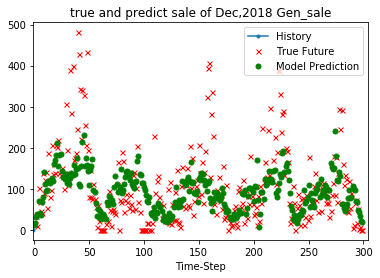

In [33]:
show_plot([[0],true_result[0:300],predic_result[0:300]],'true and predict sale of Dec,2018 Gen_sale')

### 4.1 mean of previous data

In [124]:
## baseline1: use means of all previous specific-time value: (same time in prev year)

def true_value(data,year,month,date,time,minute =0):
    return data.loc[data['TimeStamp']== dt.datetime(year,month,date,time,minute)]
def pred_value(data,pre_year,pre_month,pre_date,pre_time,nimute = 0):
    return data.loc[(data['TimeStamp'].dt.year< pre_year) & (data['TimeStamp'].dt.day==pre_date) & (data['TimeStamp'].dt.month==pre_month) & (data['TimeStamp'].dt.time == dt.time(pre_time,nimute))].mean()
def pred_value_ts(data,pre_data):
    pass
#     res = []
#     for timestamp in pre_data:
#     res.append(data.loc[(data['TimeStamp'].dt.year< pre_year) & (data['TimeStamp'].dt.day==pre_date) & (data['TimeStamp'].dt.month==pre_month) & (data['TimeStamp'].dt.time == dt.time(pre_time,nimute))].mean()
    

In [38]:
new_data = data_generator(2019,1,1,30)

### 4.2 traditional supervised learning ,previous features used like input features
1. choose feature (length):
    Year 1  
    Month 1
    date 1
    time (7:00 --> 9:45) 1
    Weekday/Weekend 7

In [146]:
## baseline2: supervised learning  feature --> value   -------> use as the final model
### training data: 11 features year,month,date,time,
### only select 11 months data as the training and test set, left Dec into final test use
train_data = data.loc[(data['TimeStamp'].dt.month< 12),['Gen_sale','Gen_items','Gen_trans','RX_filled','RX_sold','year','month','day','week','time_value']]
train_data=pd.get_dummies(train_data)
x = train_data.values[:,1:]
y_sale = train_data['Gen_sale'].values
y_

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33, random_state=31)

In [34]:
## use random forest
### this model works well, with a R^2=0.91
### hyper-parameters can be continued tuned currently depth=500, n_tree=300
regr = RandomForestRegressor(max_depth=500, random_state=0,n_estimators=300)
regr.fit(x_train, y_train)
print(regr.feature_importances_)
y_pred = regr.predict(x_test)
print(regr.score(x_train,y_train))
error = test_error(y_pred,y_test)
print(error)

[0.08344958 0.15500028 0.24212109 0.41929251 0.01104635 0.01206712
 0.01652452 0.02105413 0.01233895 0.01305998 0.0140455 ]
0.9126958993891624
4305.934602603832


In [37]:
## use adaboosting
### perform not as good as randomforest

# regr = AdaBoostRegressor(random_state=0, n_estimators=400,learning_rate = 0.005)
# regr.fit(x_train, y_train)  
# print(regr.feature_importances_)  
# y_pred = regr.predict(x_test)  
# print(regr.score(x_train, y_train))  
# error = test_error(y_pred,y_test)
# print(error)


<module 'matplotlib.pyplot' from 'D:\\Anaconda\\envs\\test_env_3.7\\lib\\site-packages\\matplotlib\\pyplot.py'>

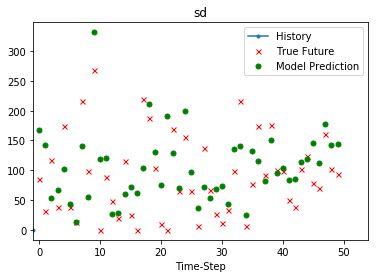

In [35]:
show_plot([[0],y_test[:50],y_pred[:50]],'sd')

## 5. build a RNN time series model
1. choose windonw function
2. design model
3. training
4. test result
#### concern:
1. this may not perform good when perdict a long period time(1 month)
#### result: I didn't choose this method, I will consider it later.

In [ ]:
## choose 2 week as data length, then will be 14*60=840
data_length = 840
## use recent 1 years as a data set
## first only use Gen_sale, this will be a univariable problem
## reform the data into 840-->input and 1--> output
## make training and test set in 7:3

def preprocessing_data(time_series_data,window_length):
    new_data = []
    new_label = []
    time_series_data = np.array(time_series_data)
    for i in range(0,len(time_series_data)):
        if i> window_length:
            new_data.append(time_series_data[i-window_length:i-1])
            new_label.append(time_series_data[i-1])
    return np.array(new_data),np.array(new_label)

In [ ]:
x,y =preprocessing_data(data['Gen_sale'][-5000:],840)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33, random_state=42)

In [145]:
class RNN():
    def __init__():
        pass

## 6. test proformance

In [30]:
def create_time_steps(pre_len,future_len):
    time_steps = []
    future = []
    for i in range(-pre_len, 0, 1):
        time_steps.append(i)
    for j in range(0,future_len):
        future.append(j)
    return time_steps,future

##  plot_data = [pre_data,fut_true,fut_pred]
def show_plot(plot_data, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    [time_steps,future] = create_time_steps(len(plot_data[0]),len(plot_data[1]))
#     if delta:
#         future = delta
#     else:
#         future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i], marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future[-1]+5)])
    plt.xlabel('Time-Step')
    return plt

In [31]:
# use MSE to test error
from sklearn.metrics import mean_squared_error as mse
def test_error(y_label,y_predict):
    result = mse(y_label,y_predict)
    return result  

## 7. output data
### --> transfer data into input format
#### use Random Forest Model as final output model

In [131]:
new_data = data_generator(2018,1,1,31)
new_pred_data = data_transform(new_data)
gen_sale = regr.predict(new_pred_data)

In [132]:
def transform(time,value,label):
    if label == 'rx_filled':
        num = 1
    elif label == 'rx_sold':
        num = 2
    elif label== 'gen_sale':
        num = 3
    elif label == 'gen_items':
        num = 4
    elif label == 'gen_trans':
        num = 5
    output = []
    for i in range(0,len(value)):
        one_data = {'BUSIND_ID': num, 'FISCAL_DATE':str(time['TimeStamp'][i].date()),'PERIOD_ID':str(time['TimeStamp'][i].time()) ,'GROUND_TRUTH':value[i]}
        output.append(one_data)
    output = pd.DataFrame(output,columns=['BUSIND_ID','FISCAL_DATE','PERIOD_ID','GROUND_TRUTH'])
    return output

In [133]:
p1 = transform(new_data,gen_sale,'gen_sale')

In [134]:
p1.head()

,BUSIND_ID,FISCAL_DATE,PERIOD_ID,GROUND_TRUTH
0,3,2018-01-01,07:00:00,24.256440
1,3,2018-01-01,07:15:00,24.256440
2,3,2018-01-01,07:30:00,43.687978
3,3,2018-01-01,07:45:00,46.912457
4,3,2018-01-01,08:00:00,46.912457


In [154]:
print(true_value(data,2018,2,2,8,30))
#print(pred_value(data,2018,1,1,9,30))

                TimeStamp  Gen_items  Gen_sale  Gen_trans  RX_filled  RX_sold  \
68842 2018-02-02 08:30:00        8.0     74.62        4.0        NaN      NaN   

             Date  year  month  day    week      Time  time_value  
68842  2018-02-02     3      2    2  Friday  08:30:00         6.0  
